Using device: cpu
Dataset and model loaded
BASELINE: CLEAN IMAGES
Accuracy: 0.9993
Precision: 1.0000
Recall: 0.9987
F1-Score: 0.9993
Mean Confidence: 0.9987
Mean Uncertainty: 0.000000
PERTURBATION 1: GAUSSIAN NOISE

Intensity: 0.05
  Accuracy: 0.9987 (drop: 0.0007)
  Mean Uncertainty: 0.000167
  Uncertainty on ERRORS: 0.018696
  Uncertainty on CORRECT: 0.000143
  Uncertainty Delta: 0.018554

Intensity: 0.1
  Accuracy: 0.9973 (drop: 0.0020)
  Mean Uncertainty: 0.000551
  Uncertainty on ERRORS: 0.023826
  Uncertainty on CORRECT: 0.000489
  Uncertainty Delta: 0.023337

Intensity: 0.15
  Accuracy: 0.9927 (drop: 0.0067)
  Mean Uncertainty: 0.001874
  Uncertainty on ERRORS: 0.040126
  Uncertainty on CORRECT: 0.001592
  Uncertainty Delta: 0.038534

Intensity: 0.2
  Accuracy: 0.9767 (drop: 0.0227)
  Mean Uncertainty: 0.005196
  Uncertainty on ERRORS: 0.064497
  Uncertainty on CORRECT: 0.003780
  Uncertainty Delta: 0.060717
PERTURBATION 2: CONTRAST SHIFT (Simulating Different CT Scanners)

Cont

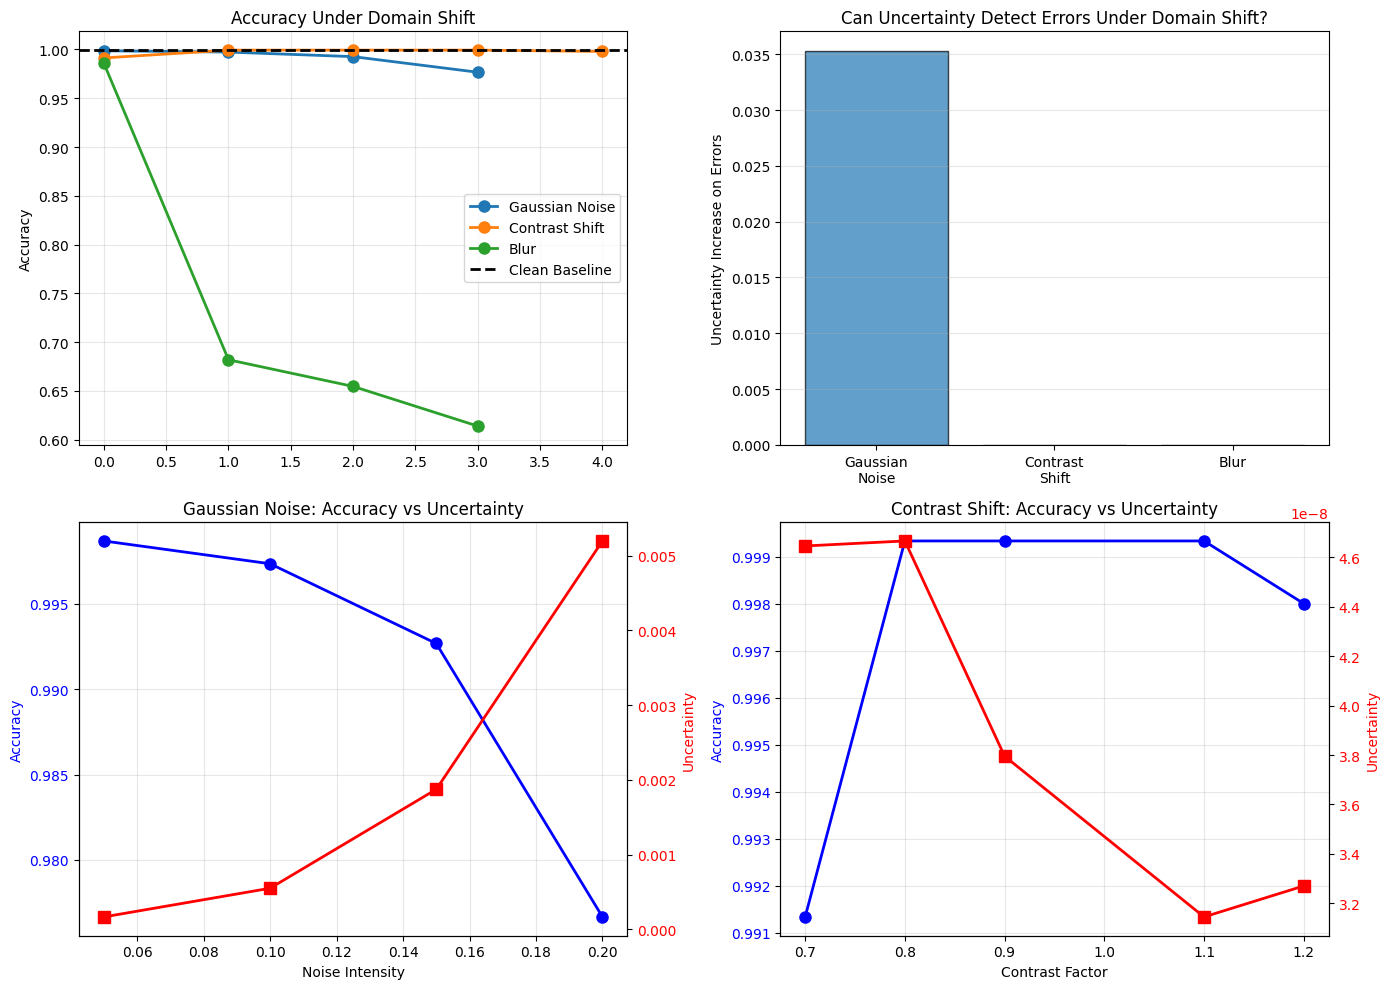


Visualization saved to results/robustness_analysis.png


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
import os
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# 1. DATASET & MODEL SETUP


class KidneyDataset(Dataset):
    def __init__(self, labels_list, data_dir, transform=None):
        self.labels_list = labels_list
        self.data_dir = data_dir
        self.transform = transform
        self.label_to_idx = {'kidney_normal': 0, 'kidney_tumor': 1}
    
    def __len__(self):
        return len(self.labels_list)
    
    def __getitem__(self, idx):
        item = self.labels_list[idx]
        img_path = os.path.join(self.data_dir, item['filename'])
        image = Image.open(img_path).convert('RGB')
        label = self.label_to_idx[item['label']]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load data
with open('data/test_labels.json', 'r') as f:
    test_labels = json.load(f)

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

test_dataset = KidneyDataset(test_labels, 'data/test', val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load baseline model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, 2)
model.load_state_dict(torch.load('checkpoints/best_model.pth'))
model = model.to(device)
model.eval()

print("Dataset and model loaded")


# 2. PERTURBATION FUNCTIONS


def add_gaussian_noise(image, intensity):
    """Add Gaussian noise to image tensor"""
    noise = torch.randn_like(image) * intensity
    return torch.clamp(image + noise, -2.1, 2.8)  # Clamp to valid range after normalization

def add_salt_pepper_noise(image, intensity):
    """Add salt & pepper noise"""
    image_np = image.permute(1, 2, 0).numpy()
    mask = np.random.random(image_np.shape) < intensity
    image_np[mask] = np.random.choice([0, 1], mask.sum())
    return torch.from_numpy(image_np).permute(2, 0, 1).float()

def contrast_shift(image, factor):
    """Simulate different CT contrast settings"""
    # Reduce intensity range (simulating different scanner settings)
    image = image * factor
    return torch.clamp(image, -2.1, 2.8)

def apply_blur(image, sigma):
    """Apply Gaussian blur (simulates image smoothing/resolution change)"""
    image_np = image.permute(1, 2, 0).numpy()
    blurred = np.stack([gaussian_filter(image_np[:,:,i], sigma=sigma) 
                       for i in range(image_np.shape[2])], axis=2)
    return torch.from_numpy(blurred).permute(2, 0, 1).float()

def rotation_translation(image, max_angle=15, max_shift=10):
    """Apply small rotation and translation"""
    from torchvision.transforms import functional as TF
    angle = np.random.uniform(-max_angle, max_angle)
    tx = np.random.randint(-max_shift, max_shift)
    ty = np.random.randint(-max_shift, max_shift)
    
    img_pil = transforms.ToPILImage()(image)
    img_pil = TF.rotate(img_pil, angle)
    img_tensor = transforms.ToTensor()(img_pil)
    
    # Apply translation
    if tx != 0 or ty != 0:
        img_tensor = TF.affine(transforms.ToPILImage()(img_tensor), 
                               angle=0, translate=(tx, ty), scale=1, shear=0)
        img_tensor = transforms.ToTensor()(img_tensor)
    
    return img_tensor

# 3. MC DROPOUT WITH PERTURBATIONS


def get_mc_dropout_predictions_perturbed(model, loader, device, perturbation_fn, 
                                        perturbation_params, n_samples=20):
    """MC Dropout predictions with image perturbations"""
    all_probs_samples = []
    all_labels = []
    all_preds = []
    
    # Enable dropout
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train()
    
    with torch.no_grad():
        for images, labels in loader:
            batch_samples = []
            
            for _ in range(n_samples):
                # Apply perturbation to this MC sample
                perturbed_images = torch.stack([
                    perturbation_fn(images[i], **perturbation_params) 
                    for i in range(images.shape[0])
                ])
                perturbed_images = perturbed_images.to(device)
                
                outputs = model(perturbed_images)
                probs = F.softmax(outputs, dim=1)
                batch_samples.append(probs.cpu().numpy())
            
            all_probs_samples.append(np.array(batch_samples))
            all_labels.extend(labels.numpy())
    
    all_probs_samples = np.concatenate(all_probs_samples, axis=1)
    all_labels = np.array(all_labels)
    
    mean_probs = all_probs_samples.mean(axis=0)
    std_probs = all_probs_samples.std(axis=0)
    
    preds = np.argmax(mean_probs, axis=1)
    uncertainty = std_probs[:, 1]
    confidence = np.max(mean_probs, axis=1)
    
    return preds, mean_probs, confidence, uncertainty, all_labels


# 4. ROBUSTNESS EVALUATION

robustness_results = {}

# Clean baseline

print("BASELINE: CLEAN IMAGES")


preds_clean, probs_clean, conf_clean, unc_clean, labels_clean = get_mc_dropout_predictions_perturbed(
    model, test_loader, device, lambda x, **kwargs: x, {}, n_samples=20
)

acc_clean = accuracy_score(labels_clean, preds_clean)
prec_clean = precision_score(labels_clean, preds_clean)
rec_clean = recall_score(labels_clean, preds_clean)
f1_clean = f1_score(labels_clean, preds_clean)

print(f"Accuracy: {acc_clean:.4f}")
print(f"Precision: {prec_clean:.4f}")
print(f"Recall: {rec_clean:.4f}")
print(f"F1-Score: {f1_clean:.4f}")
print(f"Mean Confidence: {conf_clean.mean():.4f}")
print(f"Mean Uncertainty: {unc_clean.mean():.6f}")

robustness_results['clean'] = {
    'accuracy': acc_clean,
    'precision': prec_clean,
    'recall': rec_clean,
    'f1': f1_clean,
    'mean_confidence': conf_clean.mean(),
    'mean_uncertainty': unc_clean.mean(),
    'predictions': preds_clean.tolist(),
    'confidence': conf_clean.tolist(),
    'uncertainty': unc_clean.tolist()
}


# PERTURBATION 1: GAUSSIAN NOISE



print("PERTURBATION 1: GAUSSIAN NOISE")


noise_intensities = [0.05, 0.1, 0.15, 0.2]
noise_results = {}

for intensity in noise_intensities:
    print(f"\nIntensity: {intensity}")
    preds, probs, conf, unc, labels = get_mc_dropout_predictions_perturbed(
        model, test_loader, device, add_gaussian_noise, 
        {'intensity': intensity}, n_samples=20
    )
    
    acc = accuracy_score(labels, preds)
    errors = (preds != labels).astype(int)
    
    # Uncertainty should increase when model is wrong
    unc_on_errors = unc[errors == 1].mean() if errors.sum() > 0 else 0
    unc_on_correct = unc[errors == 0].mean()
    
    print(f"  Accuracy: {acc:.4f} (drop: {acc_clean - acc:.4f})")
    print(f"  Mean Uncertainty: {unc.mean():.6f}")
    print(f"  Uncertainty on ERRORS: {unc_on_errors:.6f}")
    print(f"  Uncertainty on CORRECT: {unc_on_correct:.6f}")
    print(f"  Uncertainty Delta: {unc_on_errors - unc_on_correct:.6f}")
    
    noise_results[str(intensity)] = {
        'accuracy': acc,
        'mean_uncertainty': unc.mean(),
        'uncertainty_on_errors': unc_on_errors,
        'uncertainty_on_correct': unc_on_correct,
        'uncertainty_delta': unc_on_errors - unc_on_correct
    }

robustness_results['gaussian_noise'] = noise_results


# PERTURBATION 2: CONTRAST SHIFT



print("PERTURBATION 2: CONTRAST SHIFT (Simulating Different CT Scanners)")


contrast_factors = [0.7, 0.8, 0.9, 1.1, 1.2]
contrast_results = {}

for factor in contrast_factors:
    print(f"\nContrast Factor: {factor}")
    preds, probs, conf, unc, labels = get_mc_dropout_predictions_perturbed(
        model, test_loader, device, contrast_shift, 
        {'factor': factor}, n_samples=20
    )
    
    acc = accuracy_score(labels, preds)
    errors = (preds != labels).astype(int)
    
    unc_on_errors = unc[errors == 1].mean() if errors.sum() > 0 else 0
    unc_on_correct = unc[errors == 0].mean()
    
    print(f"  Accuracy: {acc:.4f} (drop: {acc_clean - acc:.4f})")
    print(f"  Mean Uncertainty: {unc.mean():.6f}")
    print(f"  Uncertainty Delta: {unc_on_errors - unc_on_correct:.6f}")
    
    contrast_results[str(factor)] = {
        'accuracy': acc,
        'mean_uncertainty': unc.mean(),
        'uncertainty_delta': unc_on_errors - unc_on_correct
    }

robustness_results['contrast_shift'] = contrast_results


# PERTURBATION 3: BLUR (Resolution/Smoothing Change)


print("PERTURBATION 3: BLUR (Simulating Resolution Changes)")


blur_sigmas = [0.5, 1.0, 1.5, 2.0]
blur_results = {}

for sigma in blur_sigmas:
    print(f"\nBlur Sigma: {sigma}")
    preds, probs, conf, unc, labels = get_mc_dropout_predictions_perturbed(
        model, test_loader, device, apply_blur, 
        {'sigma': sigma}, n_samples=20
    )
    
    acc = accuracy_score(labels, preds)
    errors = (preds != labels).astype(int)
    
    unc_on_errors = unc[errors == 1].mean() if errors.sum() > 0 else 0
    unc_on_correct = unc[errors == 0].mean()
    
    print(f"  Accuracy: {acc:.4f} (drop: {acc_clean - acc:.4f})")
    print(f"  Mean Uncertainty: {unc.mean():.6f}")
    print(f"  Uncertainty Delta: {unc_on_errors - unc_on_correct:.6f}")
    
    blur_results[str(sigma)] = {
        'accuracy': acc,
        'mean_uncertainty': unc.mean(),
        'uncertainty_delta': unc_on_errors - unc_on_correct
    }

robustness_results['blur'] = blur_results


# 5. SAVE RESULTS


# Convert numpy types to Python floats for JSON serialization
def convert_to_serializable(obj):
    if isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    return obj

robustness_results_serializable = convert_to_serializable(robustness_results)

with open('results/robustness_results.json', 'w') as f:
    json.dump(robustness_results_serializable, f, indent=2)


print("Robustness results saved to results/robustness_results.json")



# 6. VISUALIZATION


fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Accuracy degradation
perturbations = {
    'Gaussian Noise': noise_results,
    'Contrast Shift': {str(f): {'accuracy': contrast_results[str(f)]['accuracy']} 
                       for f in contrast_factors},
    'Blur': {str(s): {'accuracy': blur_results[str(s)]['accuracy']} 
             for s in blur_sigmas}
}

ax = axes[0, 0]
for pert_name, pert_data in perturbations.items():
    accs = [pert_data[k]['accuracy'] for k in sorted(pert_data.keys(), 
                                                     key=lambda x: float(x))]
    ax.plot(range(len(accs)), accs, 'o-', label=pert_name, linewidth=2, markersize=8)

ax.axhline(y=acc_clean, color='k', linestyle='--', label='Clean Baseline', linewidth=2)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Under Domain Shift')
ax.legend()
ax.grid(alpha=0.3)

# Plot 2: Uncertainty increase on errors
ax = axes[0, 1]
categories = ['Gaussian\nNoise', 'Contrast\nShift', 'Blur']
deltas = [
    np.mean([noise_results[str(i)]['uncertainty_delta'] for i in noise_intensities]),
    np.mean([contrast_results[str(f)]['uncertainty_delta'] for f in contrast_factors]),
    np.mean([blur_results[str(s)]['uncertainty_delta'] for s in blur_sigmas])
]

ax.bar(categories, deltas, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
ax.set_ylabel('Uncertainty Increase on Errors')
ax.set_title('Can Uncertainty Detect Errors Under Domain Shift?')
ax.grid(axis='y', alpha=0.3)

# Plot 3: Noise robustness detail
ax = axes[1, 0]
noise_accs = [noise_results[str(i)]['accuracy'] for i in noise_intensities]
noise_uncs = [noise_results[str(i)]['mean_uncertainty'] for i in noise_intensities]

ax2 = ax.twinx()
ax.plot(noise_intensities, noise_accs, 'o-', color='blue', label='Accuracy', 
        linewidth=2, markersize=8)
ax2.plot(noise_intensities, noise_uncs, 's-', color='red', label='Mean Uncertainty', 
         linewidth=2, markersize=8)

ax.set_xlabel('Noise Intensity')
ax.set_ylabel('Accuracy', color='blue')
ax2.set_ylabel('Uncertainty', color='red')
ax.set_title('Gaussian Noise: Accuracy vs Uncertainty')
ax.grid(alpha=0.3)
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')

# Plot 4: Contrast robustness detail
ax = axes[1, 1]
contrast_factors_sorted = sorted(contrast_factors)
contrast_accs = [contrast_results[str(f)]['accuracy'] for f in contrast_factors_sorted]
contrast_uncs = [contrast_results[str(f)]['mean_uncertainty'] for f in contrast_factors_sorted]

ax2 = ax.twinx()
ax.plot(contrast_factors_sorted, contrast_accs, 'o-', color='blue', label='Accuracy', 
        linewidth=2, markersize=8)
ax2.plot(contrast_factors_sorted, contrast_uncs, 's-', color='red', label='Mean Uncertainty', 
         linewidth=2, markersize=8)

ax.set_xlabel('Contrast Factor')
ax.set_ylabel('Accuracy', color='blue')
ax2.set_ylabel('Uncertainty', color='red')
ax.set_title('Contrast Shift: Accuracy vs Uncertainty')
ax.grid(alpha=0.3)
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.savefig('results/robustness_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to results/robustness_analysis.png")
